<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Andrew/sources/stock_predictor_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Set plot stylizations

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

In [3]:
def getStockData(ticker: str, constRange: str='5y'):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?region=US&lang=en-US&includePrePost=false&interval=1d&useYfid=true&range=" + constRange + "&corsDomain=finance.yahoo.com&.tsrc=finance"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    return df

def toDatetime(t):
    return datetime.fromtimestamp(t)

# Method for getting ticker data using Yahoo Finance API

This method downloads json data from the Yahoo! finance API and organizes it into a Pandas dataframe. The time frame of the data can start and end wherever the user wants it to. The start and end dates need to be a String in the form of a Unix Timestamp.

In [4]:
def getStockDataInRange(ticker: str, startDate: str, endDate: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?period1=" + startDate + "&period2=" + endDate + "&useYfid=true&interval=1d&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=Yo9B6QaqJUD&corsDomain=finance.yahoo.com"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    # Difference if based on 'close' price
    df['diff'] = df['close'].diff()
    df['change'] = df['diff'] / df['close'].shift(periods=1) * 100
    return df

def toDatetime(t):
    return datetime.fromtimestamp(t)

# Creating Dataframe with stock data from QQQ

In [5]:
ticker = 'QQQ'
endDate = datetime(year=2020, month=12, day=31, hour=0, minute=0).strftime('%s')
startDate = datetime(year=2010, month=1, day=1, hour=0, minute=0).strftime('%s')

df = getStockDataInRange(ticker=ticker, startDate=startDate, endDate=endDate)

# Showing Dataframe head

In [6]:
df.head()

,timestamps,open,high,low,close,volume,diff,change
0,2010-01-04 14:30:00,46.330002,46.490002,46.270000,46.419998,62822800,NaN,NaN
1,2010-01-05 14:30:00,46.389999,46.500000,46.160000,46.419998,62935600,0.000000,0.000000
2,2010-01-06 14:30:00,46.400002,46.549999,46.070000,46.139999,96033000,-0.279999,-0.603186
3,2010-01-07 14:30:00,46.209999,46.270000,45.919998,46.169998,77094100,0.029999,0.065017
4,2010-01-08 14:30:00,46.070000,46.549999,45.930000,46.549999,88886600,0.380001,0.823048


# Function for plotting stock prices of data frame

In [7]:
def visualize_prices(df, x_values, y_values):
    ax = df.plot(x=x_values, y=[y_values], kind='line', title=ticker + ' prices in set range')
    vals = ax.get_yticks()
    ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    plt.show()

# Plotting QQQ open prices from January 1, 2010 to the December 31, 2020 using Unix Timestamps

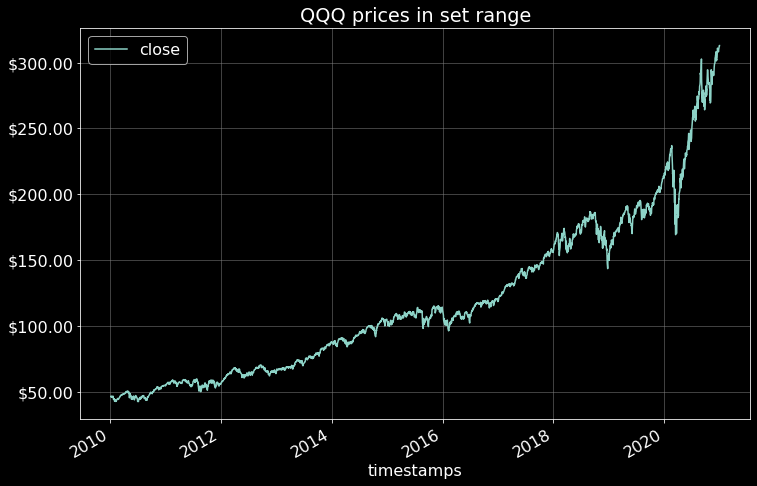

In [8]:
visualize_prices(df, 'timestamps', 'close')

# Creating Training Data

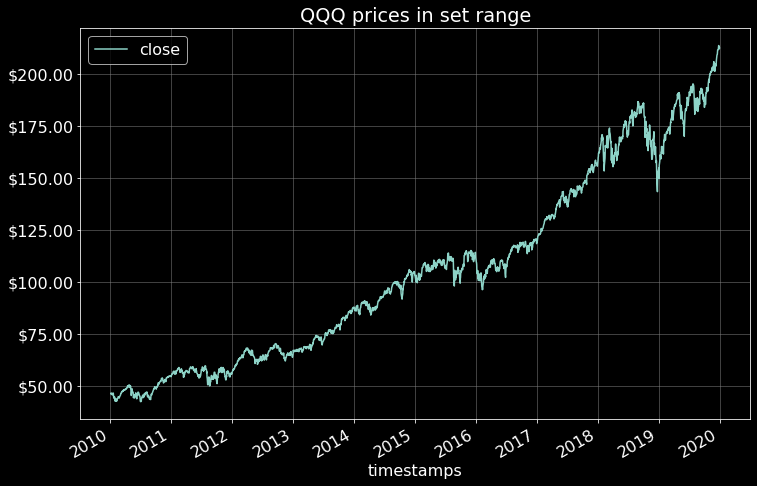

In [9]:
training_data = df[df['timestamps']<'2020-01-01'].copy()
visualize_prices(training_data, 'timestamps', 'close')

training_data = training_data.drop(['timestamps'], axis=1)
training_data = training_data.iloc[1:]    # Drops first row in dataframe
training_copy = training_data   # Need this to append last n row to testing data later

# Creating Testing Data

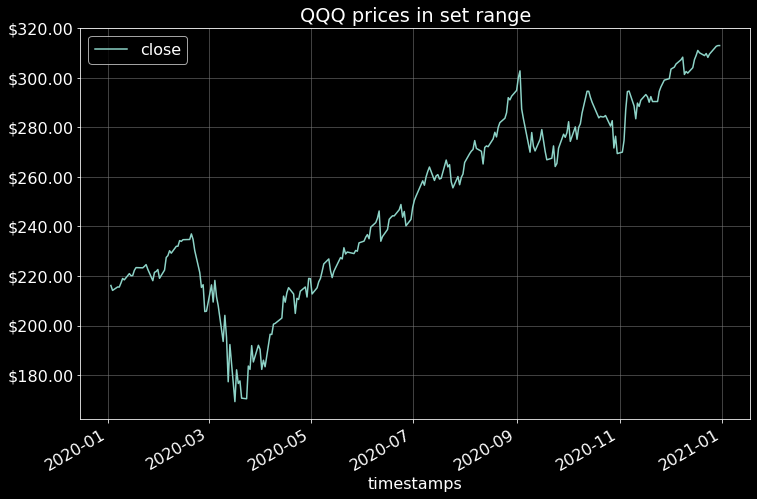

In [10]:
test_data_w_ts = df[df['timestamps']>='2020-01-01'].copy()
visualize_prices(test_data_w_ts, 'timestamps', 'close')

test_data = test_data_w_ts.drop(['timestamps'], axis=1)
test_data = test_data.iloc[1:]    # Drops first row in dataframe

In [11]:
# data_train_copy = df[df['timestamps']<'2020-01-01'].copy()
# data_train_copy

In [12]:
# data_test_copy = df[df['timestamps']>='2020-01-01'].copy()
# data_test_copy

In [13]:
# training_data = data_train_copy.drop(['timestamps'], axis=1)
# training_data.head()

# Normalize data between 0 and 1

In [14]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data.shape

(2515, 7)

# Create data with time_step = 10

In [15]:
time_step = 10

X_train = []
y_train = []
for i in range(time_step, training_data.shape[0]):
    X_train.append(training_data[i-time_step:i])
    y_train.append(training_data[i, 3]) # Fill y_train with close prices

print(len(y_train))

2505


# Examine shape of *x_train* and *y_train*

In [16]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2505, 10, 7), (2505,))

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [18]:
model = Sequential([
    LSTM(
        units=60, 
        activation='relu', 
        return_sequences=True, 
        input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(
        units=60, 
        activation='relu', 
        return_sequences=True),
    Dropout(0.2),
    LSTM(
        units=80, 
        activation='relu', 
        return_sequences=True),
    Dropout(0.2),
    LSTM(
        units=120, 
        activation='relu'),
    Dropout(0.2),
    Dense(units=1)
])
# regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50))
# regressor.add(Dropout(0.2))
# regressor.add(Dense(units = 1))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 60)            16320     
_________________________________________________________________
dropout (Dropout)            (None, 10, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
79/79 [==============================] - 7s 29ms/step - loss: 0.0712
Epoch 2/50
79/79 [==============================] - 2s 28ms/step - loss: 0.0036
Epoch 3/50
79/79 [==============================] - 2s 30ms/step - loss: 0.0027
Epoch 4/50
79/79 [==============================] - 2s 29ms/step - loss: 0.0020
Epoch 5/50
79/79 [==============================] - 2s 29ms/step - loss: 0.0019
Epoch 6/50
79/79 [==============================] - 2s 28ms/step - loss: 0.0020
Epoch 7/50
79/79 [==============================] - 2s 28ms/step - loss: 0.0018
Epoch 8/50
79/79 [==============================] - 2s 28ms/step - loss: 0.0014
Epoch 9/50
79/79 [==============================] - 2s 28ms/step - loss: 0.0018
Epoch 10/50
79/79 [==============================] - 2s 28ms/step - loss: 0.0017
Epoch 11/50
79/79 [==============================] - 2s 28ms/step - loss: 0.0015
Epoch 12/50
79/79 [==============================] - 2s 29ms/step - loss: 0.0014
Epoch 13/50
79/79 [==================

# Creating test data

In [22]:
past_n_data_points = training_copy.tail(time_step)
past_df = past_n_data_points.append(test_data, ignore_index=True)
#past_df = past_df.drop(['timestamps'], axis=1)
past_df.head()

,open,high,low,close,volume,diff,change
0,209.539993,209.710007,209.039993,209.389999,15996100,0.119995,0.057340
1,209.570007,210.130005,209.330002,209.550003,15443300,0.160004,0.076414
2,209.639999,210.929993,209.619995,210.860001,17865900,1.309998,0.625148
3,211.860001,212.520004,211.270004,211.710007,27672600,0.850006,0.403114
4,212.000000,212.149994,211.630005,211.809998,23774700,0.099991,0.047230


# Scaling inputs back up from between 0 and 1 to the original

In [23]:
inputs = scaler.transform(past_df)
inputs.shape

(261, 7)

# Creating x_test and y_test with time_step = 10

In [24]:
X_test = []
y_test = []
for i in range(time_step, inputs.shape[0]):
    X_test.append(inputs[i-time_step:i])
    y_test.append(inputs[i, 0]) 

# Analyzing shape of x_test and y_test

In [25]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((251, 10, 7), (251,))

# Predict the price of the next day

In [26]:
y_pred = model.predict(X_test)
y_pred.shape

(251, 1)

# Scale y_test and y_pred to be on the same scale

In [27]:
y_pred = y_pred/scaler.scale_[0]
y_test = test_data_w_ts[1:]['close'].values
y_pred.shape, y_test.shape

((251, 1), (251,))

In [28]:
values = test_data_w_ts[1:]['close'].values
values.shape

(251,)

# Vizualization of real vs predicted prices

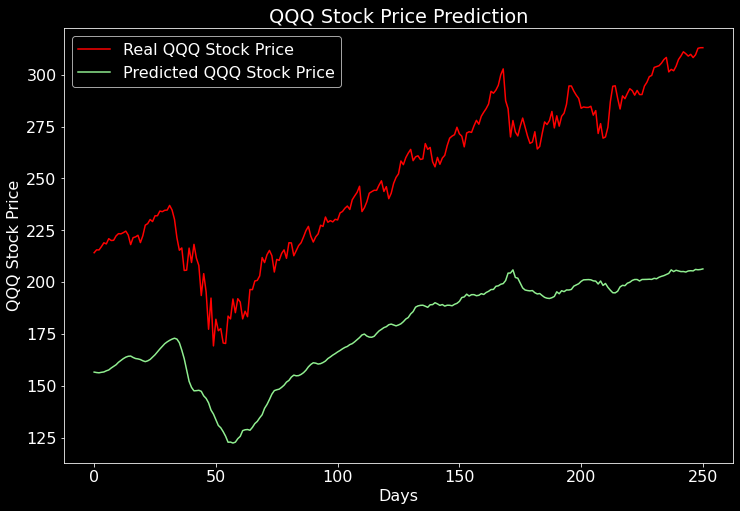

In [29]:
fig = plt.figure()
plt.plot(y_test, color='red', label='Real ' + ticker + ' Stock Price')
plt.plot(y_pred, color='lightgreen', label='Predicted ' + ticker + ' Stock Price')
plt.title(ticker + " Stock Price Prediction")
plt.xlabel('Days')
plt.ylabel(ticker + ' Stock Price')
plt.legend()
plt.show()

In [30]:
accuracy = 0

for i in range(1, y_test.shape[0]):

    # Determining if the actual price increased
    price_did_increase = y_test[i] > y_test[i-1]
    # Determining if the predicted price increased
    model_predicted_increase = y_pred[i] > y_pred[i-1]
    # If both the actual and predicted prices move in the same direction, 
    # then add 1 to the accuracy
    if (price_did_increase == model_predicted_increase):
        accuracy = accuracy + 1

print("Model accuracy: {:.3f}%".format(accuracy / (y_test.shape[0] - 1) * 100))

Model accuracy: 53.600%


# Implementation of trading algorithm

* In this implementation, we assume that fractional shares are available to us to trade
* We prevent the model from owning less than 10 shares after it has purchased more than 10
* We prevent the model from have less than $500 USD on hand at any time

In [40]:
model_variation = []
price_variation = []
buy_points = []
sell_points = []
share_hist = []
cash_hist = []

maximum_trade_size = 3000.00
cash_on_hand = 10000.00
initial_value = cash_on_hand
number_of_shares = 0.00


for i in range(1, y_pred.shape[0]):
    # Current prediction price
    current_pred = y_pred[i][0]
    # Previous prediction price
    previous_pred = y_pred[i-1][0]
    # Current actual price
    current_actual= y_test[i]
    # Previous actual price
    previous_actual = y_test[i-1]

    change = ((current_pred - previous_pred) / previous_pred) * 100

    #print(change)

    if (change >= 1.0):
        #print("Buy" + str(change) + "%")
        # The model is expecting the share price to increase
        # Use previous actual price to determine how many shares to buy
        maximum_allow_trade_size = min(maximum_trade_size, cash_on_hand)
        if ((cash_on_hand - maximum_trade_size) < 500):
            maximum_allow_trade_size = maximum_allow_trade_size - 500
        shares_to_buy = maximum_allow_trade_size / previous_actual
        number_of_shares = number_of_shares + shares_to_buy
        cash_on_hand = cash_on_hand - (shares_to_buy * previous_actual)
        buy_points.append(i-1)
    elif (change <= -1.5):
        #print("Sell: " + str(change) + "%")
        # The model is expecting the share price to decrease
        # Use previous price to determine how many shares to sell
        shares_to_sell = min(round(maximum_trade_size / previous_actual, 4), number_of_shares)
        # Prevents model from selling sharing shares if the resulting number of shares after sale is less than 10
        if ((number_of_shares - shares_to_sell) < 10):
            shares_to_sell = 0
        number_of_shares = number_of_shares - shares_to_sell
        cash_on_hand = cash_on_hand + (shares_to_sell * previous_actual)
        sell_points.append(i-1)

    starting_price = y_test[1]

    price_variation.append((current_actual - starting_price) / starting_price * 100)
    model_variation.append((cash_on_hand + (number_of_shares * current_actual) - initial_value) / initial_value * 100)
    # Append to share # history
    share_hist.append(number_of_shares)
    # Append to cash history
    cash_hist.append(cash_on_hand)

end_price = y_test[-1]
share_value = end_price * number_of_shares

print("Cash left on hand: ${:.3f}".format(cash_on_hand))
print("Number of shares: {:.3f}".format(number_of_shares))
print("Value of shares: {:.3f}".format(share_value))
print("Total value: ${:.3f}".format(cash_on_hand + share_value))

print("Number of trades: {:.3f}".format(len(buy_points) + len(sell_points)))

Cash left on hand: $500.000
Number of shares: 49.811
Value of shares: 15589.390
Total value: $16089.390
Number of trades: 28.000


# Create a Dataframe that contains the performance metrics of the model

In [41]:
p_df = pd.DataFrame()
p_df['timestamps'] = test_data_w_ts[2:]['timestamps'].values
p_df['model_var'] = model_variation
p_df['price_var'] = price_variation
p_df['stock_hist'] = share_hist
p_df['cash_hist'] = cash_hist

# Visualizing Model Performance vs. Stock Price Change

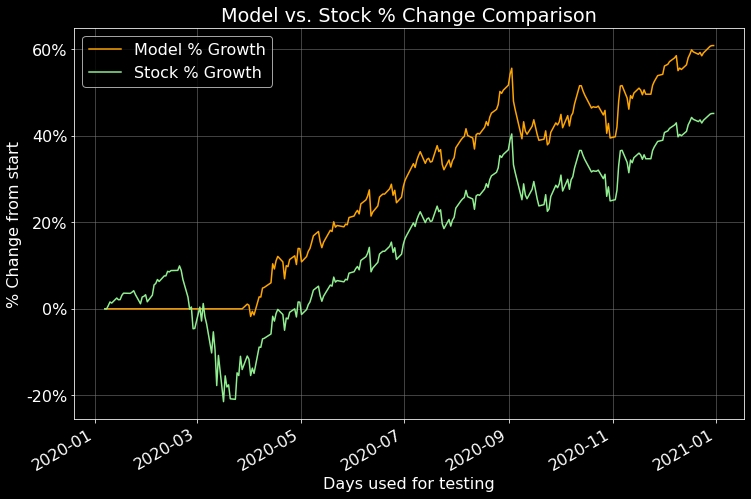

In [42]:
def visualize_performance():

    ax = p_df.plot(x='timestamps', y=['model_var', 'price_var'], color=['orange', 'lightgreen'])

    vals = ax.get_yticks()
    ax.set_yticklabels(['{:1.0f}%'.format(x) for x in vals])
    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    ax.legend(['Model % Growth', 'Stock % Growth'])
    ax.set_ylabel('% Change from start')
    ax.set_xlabel('Days used for testing')
    ax.set_title('Model vs. Stock % Change Comparison')

visualize_performance()

# Method for visualizing when the model decided to BUY/SELL and how the value of the model compares against the actual stock price

In [44]:
import matplotlib.ticker as mtick

def marker_visualization(markers, title):
    fig, (ax) = plt.subplots(1, 1, sharex=True)

    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)

    ax.plot(price_variation, label='Stock % Growth', color='lightgreen', markevery=markers, marker='o', markerfacecolor='white')
    ax.plot(model_variation, label='Model % Growth', color='orange',)

    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    ax.legend(loc='upper left')

    ax.set_ylabel('% Change from start')
    ax.set_xlabel('Number of Days')
    ax.set_title(title)

# Model vs. Stock % Change with Predicted Buy Markers

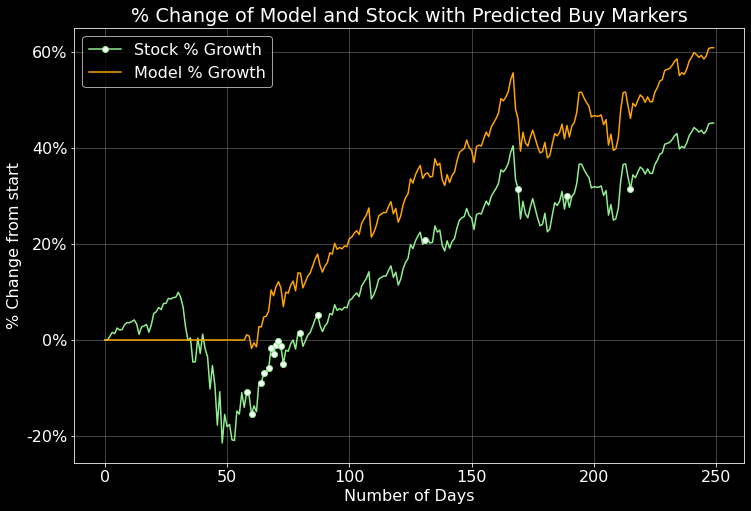

In [45]:
marker_visualization(markers=buy_points, title='% Change of Model and Stock with Predicted Buy Markers')

# Model vs. Stock % Change with Predicted Sell Markers

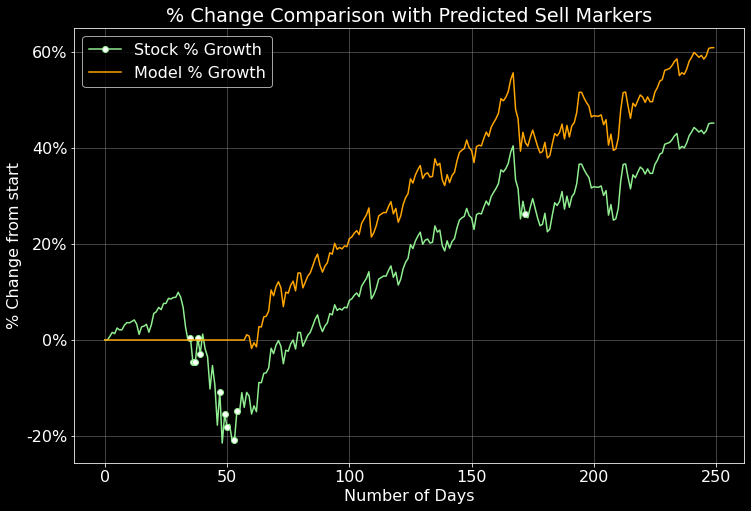

In [46]:
marker_visualization(markers=sell_points, title='% Change Comparison with Predicted Sell Markers')

# Visualizing the number of shares and the amount of cash over the course of the trading cycle

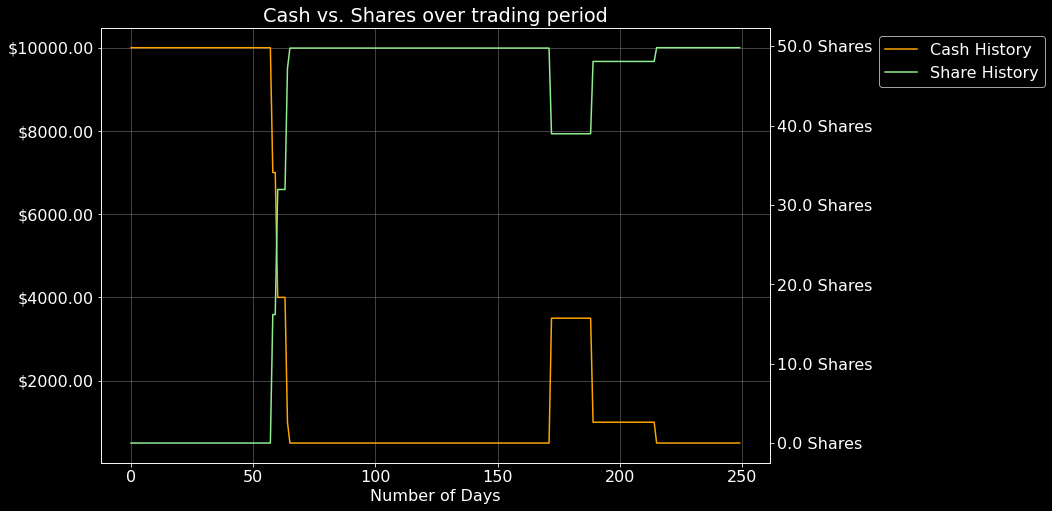

In [47]:
def visualize_asset_value_over_time():
    fig, (ax) = plt.subplots(1, 1, sharex=True)

    line_1 = ax.plot(cash_hist, color='orange', label='Cash History')
    vals = ax.get_yticks()
    ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    ax2 = ax.twinx()      # Add a secondary axis
    line_2 = ax2.plot(share_hist, color='lightgreen', label='Share History')
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:1.1f} Shares'.format(x) for x in vals])

    lns = line_1 + line_2
    labs = [l.get_label() for l in lns]

    ax.legend(lns, labs, bbox_to_anchor=(1.15, 1), loc='upper left')
    ax.set_title("Cash vs. Shares over trading period")
    ax.set_xlabel('Number of Days')


visualize_asset_value_over_time()